In [1]:
import pandas as pd
from mira.modeling import Concept, TemplateModel, Annotations
from mira.sources.system_dynamics.vensim import template_model_from_mdl_url, template_model_from_mdl_file
from mira.modeling.amr.stockflow import template_model_to_stockflow_json
import os
import json
from pathlib import Path

In [2]:
HERE = Path(".").resolve()

## Grounding Map

Load a custom grounding map, which lets us assign identifiers and contexts to most of the compartments.

In [3]:
grounding_map_df = pd.read_csv("grounding_map.csv")
grounding_map_df

,name,mapped_identifiers,mapped_context
0,susceptibles,ido:0000514/susceptible population,NaN
1,exposed,apollosv:00000154/exposed population,NaN
2,cumulative_cases_reported,ncit:C175885/Number of Cases,NaN
3,infectious_asymptomatics,ido:0000511/infected population,disease_status=ncit:C3833/Asymptomatic
4,dead,ncit:C28554/Dead,NaN
5,isolated_asymptomatics,ido:0000511/infected population,disease_status=ncit:C3833/Asymptomatic|mobilit...
6,quarantined_asymptomatics,ido:0000511/infected population,disease_status=ncit:C3833/Asymptomatic|mobilit...
7,recovered_asymtomatics,ido:0000592/immune population,disease_status=ncit:C3833/Asymptomatic
8,isolated_symtomatics_mild,ido:0000511/infected population,disease_status=ncit:C25269/Symptomatic|mobilit...
9,recovered_isolated_symptomatic_mild,ido:0000592/immune population,disease_status=ncit:C25269/Symptomatic|mobilit...


In [4]:
def curie_to_identifiers(curie):
    prefix, identifier = curie.split(":")
    return {prefix: identifier}

grounding_map = {}
for display_name, identifiers, context_str in grounding_map_df.values:
    if pd.isna(identifiers):
        continue
    curie, name =  identifiers.split("/")
    context = {}
    if pd.notna(context_str):
        for part in context_str.split("|"):
            part_key, part_identifier = part.split("=")
            if "/" in part_identifier:
                part_curie, part_name = part_identifier.split("/")
            else:
                part_curie, part_name = part_identifier, None
            # print(curie, name, part_key, part_curie, part_name)
            context[part_key] = part_curie
            
    grounding_map[display_name] = Concept(
        name=name, 
        display_name=display_name,
        identifiers=curie_to_identifiers(curie),
        context=context,
    )

## Ingest the hackathon Vensim model and display its structure

In [5]:
hackathon_file_path = "IndiaNonSubscriptedPulsed.mdl"
hackathon_file_url = (
    "https://raw.githubusercontent.com/DARPA-ASKEM/program-milestones/main/18-"
    "month-milestone/hackathon/epi/Scenario%205%20Supplemental/IndiaNonSubscriptedPulsed.mdl"
)

if os.path.exists(hackathon_file_path):
    tm = template_model_from_mdl_file(hackathon_file_path, grounding_map=grounding_map)
else:
    tm = template_model_from_mdl_url(hackathon_file_url, grounding_map=grounding_map)

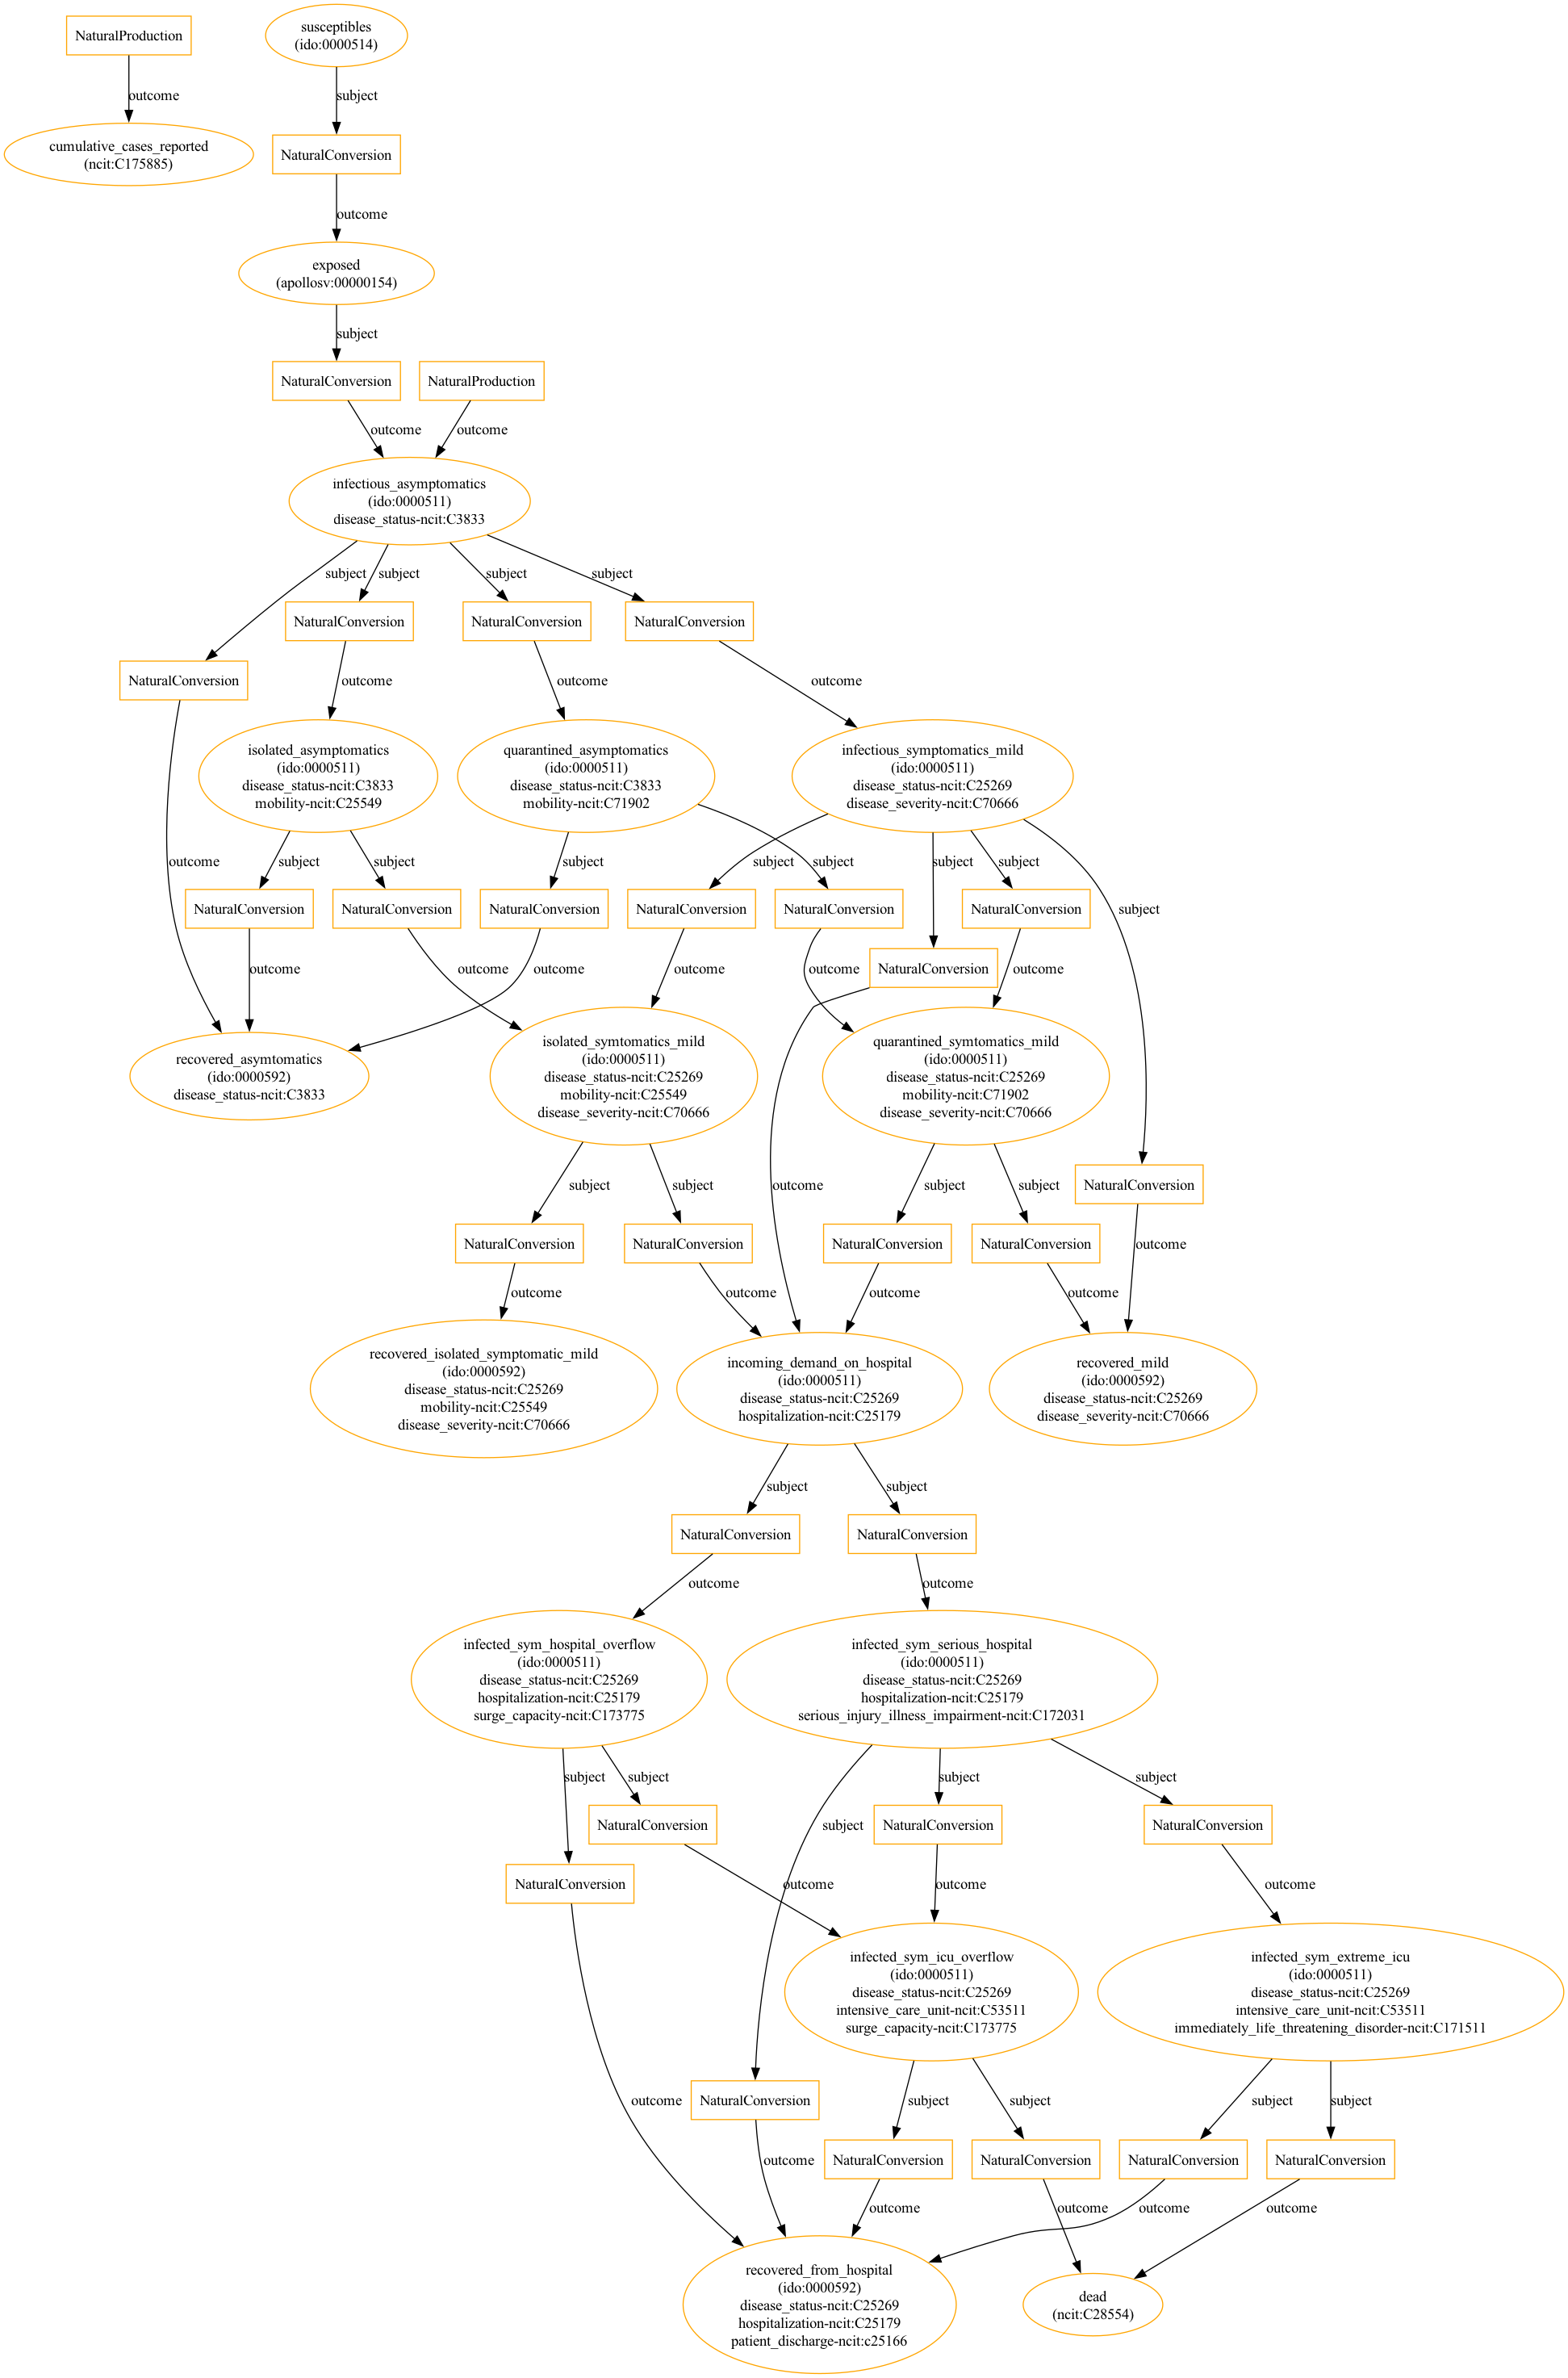

In [6]:
tm.draw_jupyter('scenario5.png')

## Print the parameters and their values

In [7]:
rows = [
    (parameter_name, parameter.value)
    for parameter_name, parameter in tm.parameters.items()
]
pd.DataFrame(rows, columns=["name", "value"])

,name,value
0,open_duration,10.0
1,end_lockdown_time,400.0
2,lockdown_period,0.0
3,high_contact_tracing_and_isolation,0.0
4,net_fr_requiring_icu,0.0
...,...,...
129,sum_recovered_asym,0.0
130,sum_recovered_mild,0.0
131,sumnoninfectives,0.0
132,recoveries_serioush_overflow,0.0


## Print the templates and their associated rate laws

A majority of rate laws for templates are the placeholder value of 0 as their rate-laws contain built-in Vensim functions and involve operations with series data which MIRA does not support yet.

In [8]:
template_rate_laws = [
    (template.name, template.rate_law)
    for template in tm.templates
]
pd.DataFrame(template_rate_laws, columns=["name", "rate_law"])

,name,rate_law
0,1,disease_progression + isolation_rate_asym + is...
1,2,0
2,3,0
3,4,contacts_total_per_susceptible*infectivity*sus...
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


## Display the output Stock and Flow amr for the MIRA template model created from ingesting the Vensim model

In [9]:
# FIXME need to get header information in there correctly

annotations = Annotations(name="February 2024 Hackathon - Scenario 5")
tm.annotations = annotations

amr = template_model_to_stockflow_json(tm)
HERE.joinpath("scenario_5_stockflow.json").write_text(json.dumps(amr, indent=2))
amr

{'header': {'name': 'February 2024 Hackathon - Scenario 5',
  'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/stockflow_v0.1/stockflow/stockflow_schema.json',
  'description': 'February 2024 Hackathon - Scenario 5',
  'schema_name': 'stockflow',
  'model_version': '0.1'},
 'properties': {},
 'model': {'flows': [{'id': '1',
    'name': 'new_cases_reported',
    'upstream_stock': None,
    'downstream_stock': 'cumulative_cases_reported',
    'rate_expression': 'disease_progression + isolation_rate_asym + isolation_rate_sym + q_disease_progress_rate',
    'rate_expression_mathml': '<apply><plus/><ci>disease_progression</ci><ci>isolation_rate_asym</ci><ci>isolation_rate_sym</ci><ci>q_disease_progress_rate</ci></apply>'},
   {'id': '2',
    'name': 'deaths',
    'upstream_stock': 'infected_sym_extreme_icu',
    'downstream_stock': 'dead',
    'rate_expression': '0',
    'rate_expression_mathml': '<cn>0</cn>'},
   {'id': '3',
    'name': 'deaths_overflow',
    